In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
data = pd.read_csv('/kaggle/input/faceexpression-dp/data.csv')
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


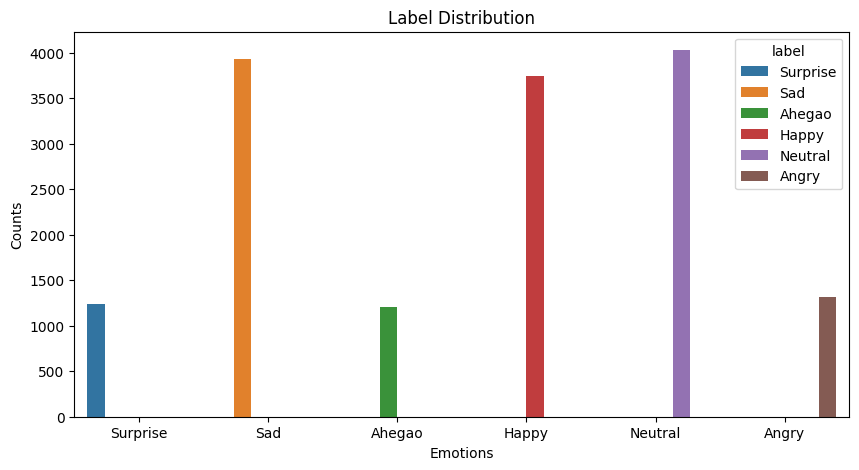

In [5]:
# Getting the label distribution
plt.figure(figsize=(10, 5))
plt.title("Label Distribution")
sns.countplot(data, x='label', hue='label')
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.show()

In [6]:
# convert the path to full path till the image
image_dir = "/kaggle/input/faceexpression-dp/dataset"

In [7]:
# Define Dataset parameters
TARGET_IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
image_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2
)

#training the dataset
train_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    subset = 'training',
    shuffle = True
)

#testing the dataset
test_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    subset = 'training',
    shuffle = True
)

class_index = train_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}

Found 12365 images belonging to 6 classes.
Found 12365 images belonging to 6 classes.


In [9]:
print(class_index)

{'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


(32, 224, 224, 3)


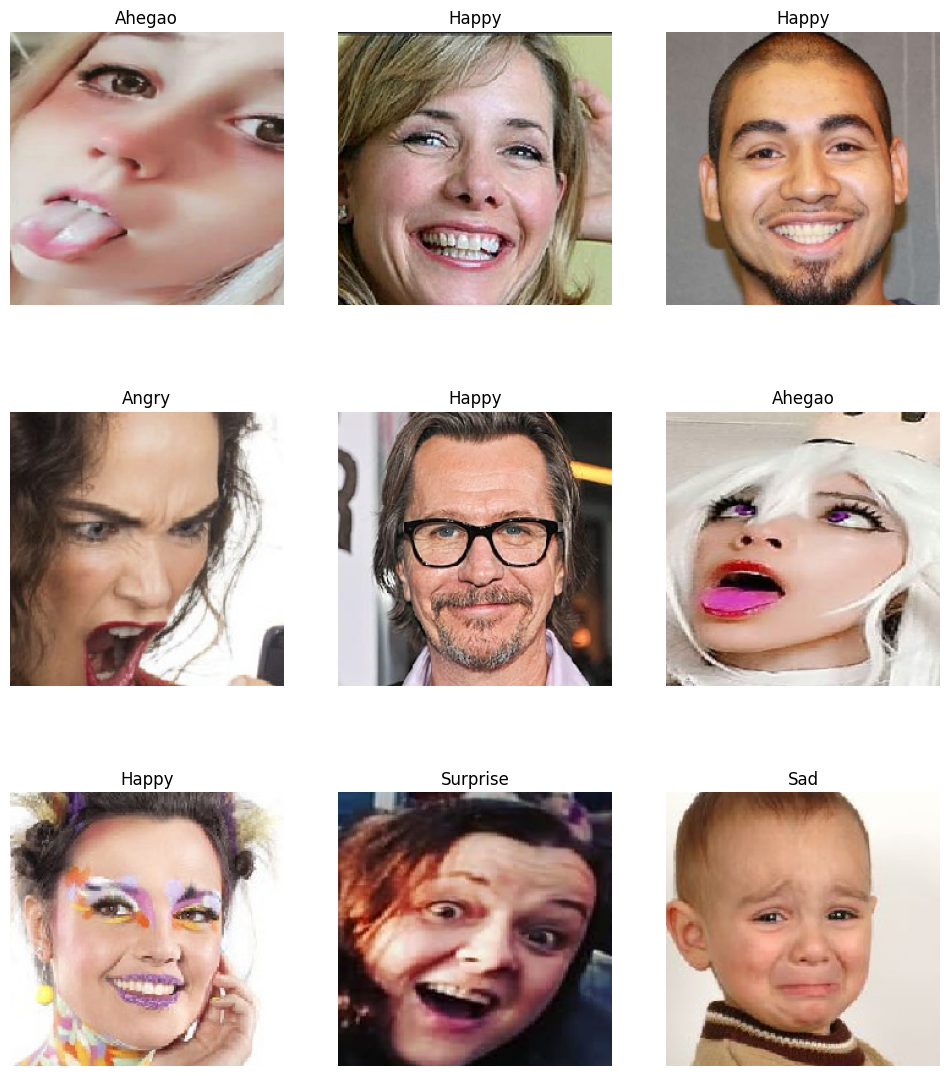

In [10]:
plt.figure(figsize=(12, 14))
for img, label in train_datagen:
    print(img.shape)
    label = np.argmax(label, axis=1)
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(f"{index_class[label[i]]}")
        plt.imshow(img[i])
        plt.axis('off')
    plt.show()
    break

In [11]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-_a22p7wo
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-_a22p7wo
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=e464eac3b388d9821ac701c88f35418734319c715e07f4a02b10e84bae6555d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-tfxemgq6/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 866.1 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
# check version of keras_vggface
import keras_vggface
from keras_vggface.vggface import VGGFace
# print version
print(keras_vggface.__version__)

0.6


In [14]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

def create_model(img_shape, num_classes, fine_tune = 0, drop_out=0.1):
    vgg_model = VGGFace(model = 'vgg16',weights='vggface',include_top=False, input_shape=img_shape, pooling = 'avg')
    # Freeze all the layers
    for layer in vgg_model.layers:
        layer.trainable = False
    
    # Unfreeze certain layers
    if fine_tune != 0:
        for layer in vgg_model.layers[fine_tune:]:
            layer.trainable = True
    
    
    base_model_output = vgg_model.output
    
    dropout1 = Dropout(drop_out)(base_model_output)
    dense1 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(drop_out)(dense1)
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    return Model(inputs=vgg_model.input, outputs=output)

In [15]:
model = create_model((*TARGET_IMG_SIZE, 3), 6)

58909280/58909280 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [17]:
oup = model(img[:2])
print(oup.shape)

(2, 6)


In [18]:
checkpoint = ModelCheckpoint("models/face_expression_new.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                         restore_best_weights=True,
                         patience=5)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.2,
                               patience=2)

callbacks = [earlystop, checkpoint,Reducing_LR]

In [19]:
model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.00001),
                        metrics=['accuracy'])

In [20]:
EPOCHS = 5
history = model.fit(train_datagen, epochs=EPOCHS, validation_data=test_datagen, callbacks=callbacks)

Epoch 1/5
387/387 [==============================] - 269s 674ms/step - loss: 1.7741 - accuracy: 0.2664 - val_loss: 1.7573 - val_accuracy: 0.3119 - lr: 1.0000e-05
Epoch 2/5
387/387 [==============================] - 163s 423ms/step - loss: 1.7381 - accuracy: 0.3177 - val_loss: 1.7182 - val_accuracy: 0.3612 - lr: 1.0000e-05
Epoch 3/5
387/387 [==============================] - 163s 421ms/step - loss: 1.7004 - accuracy: 0.3555 - val_loss: 1.6835 - val_accuracy: 0.3858 - lr: 1.0000e-05
Epoch 4/5
387/387 [==============================] - 164s 423ms/step - loss: 1.6709 - accuracy: 0.3694 - val_loss: 1.6575 - val_accuracy: 0.4168 - lr: 1.0000e-05
Epoch 5/5
387/387 [==============================] - 162s 419ms/step - loss: 1.6476 - accuracy: 0.3923 - val_loss: 1.6377 - val_accuracy: 0.4349 - lr: 1.0000e-05


In [21]:
model.save("model.keras")

In [24]:
# Method to plot the train performance
def plot_training_performance(history, metrics):
    plt.figure(figsize=(14, 12))
    
    for i, metrics in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        val_metrics = "val_" + metrics
        
        plt.title(f"{metrics} vs {val_metrics}")
        plt.plot(history.history[metrics], label=metrics)
        plt.plot(history.history[val_metrics], label=val_metrics)
        plt.grid(True)
        plt.xlabel("Epochs")
        plt.ylabel(metrics)
        plt.legend()
    
    plt.show()

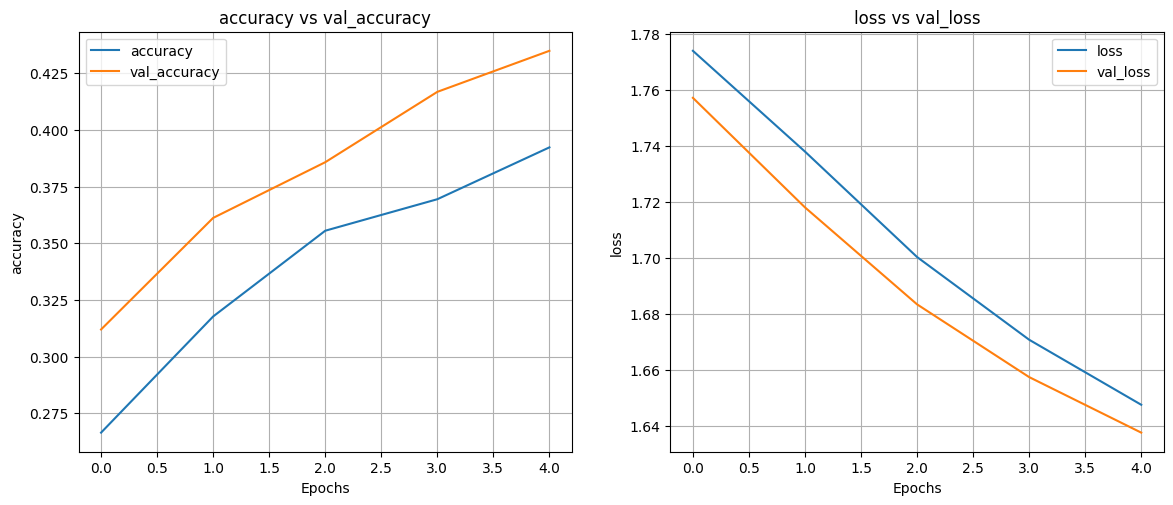

In [25]:
plot_training_performance(history, ['accuracy', 'loss'])

From above graph it can be deduced that my model is neither overfitting nor underfitting it was generally not performing well. So, need to perform data augmentation to imporve the model to learn better.


# Fine Tuning 1

In [26]:
image_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split=0.2,
    rotation_range=45,
    horizontal_flip=True,
    shear_range=45,
    zoom_range=0.1
)

#Define training dataset
train_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size=TARGET_IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True
)

#Define validation dataset
test_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size=TARGET_IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=True
)

class_index = train_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


(32, 224, 224, 3)


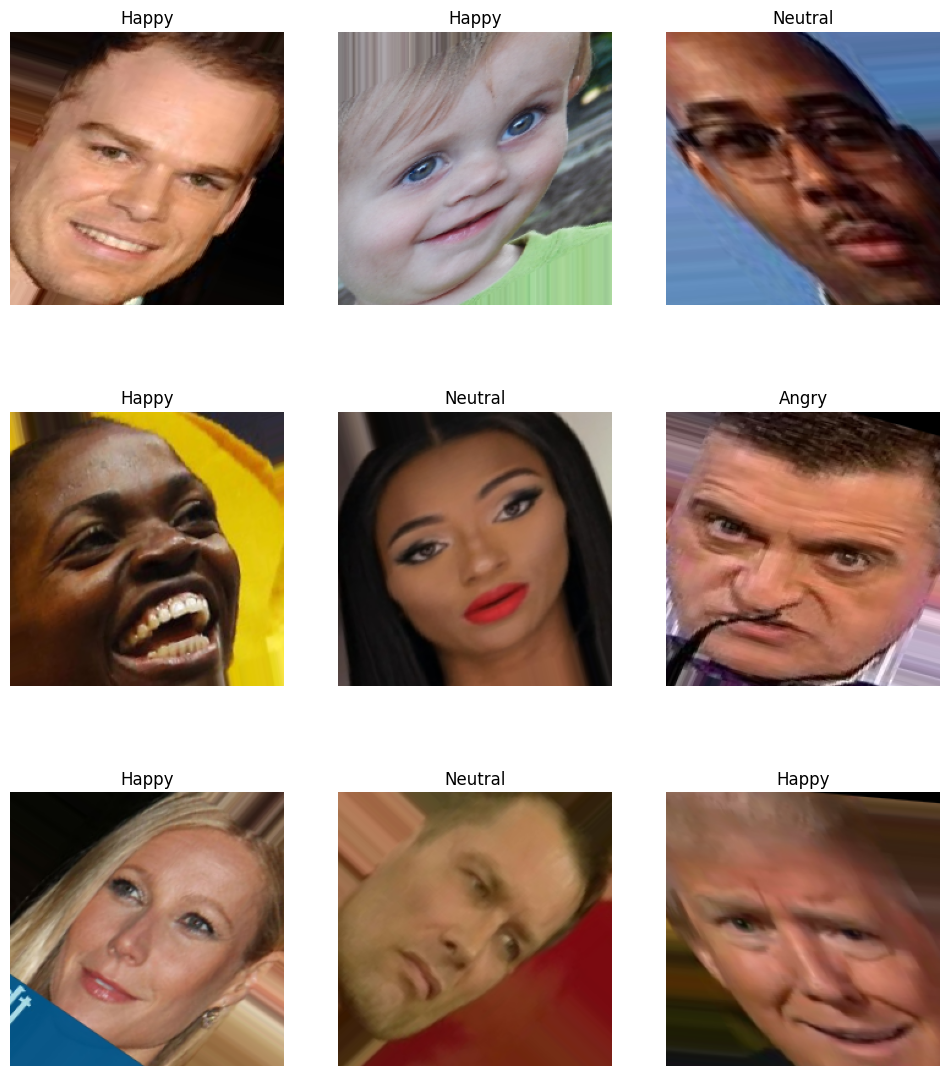

In [27]:
plt.figure(figsize=(12, 14))
for img, label in train_datagen:
    print(img.shape)
    label = np.argmax(label, axis=1)
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(f"{index_class[label[i]]}")
        plt.imshow(img[i])
        plt.axis('off')
    break

In [28]:
model2 = create_model((*TARGET_IMG_SIZE, 3), 6)

In [30]:
EPOCHS = 20
decay_steps = train_datagen.n * EPOCHS

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 1e-4,
    decay_steps=decay_steps,
    end_learning_rate = 1e-5,
)

model2.compile(
    loss='categorical_crossentropy',
    optimizer=lr_scheduler,
    metrics=['accuracy']
)

In [31]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [32]:
history = model2.fit(train_datagen, epochs=EPOCHS, validation_data=test_datagen, callbacks=callbacks)

Epoch 1/20
387/387 [==============================] - 289s 743ms/step - loss: 1.6878 - accuracy: 0.2965 - val_loss: 1.6356 - val_accuracy: 0.3611 - lr: 1.0000e-04
Epoch 2/20
387/387 [==============================] - 251s 650ms/step - loss: 1.6062 - accuracy: 0.3857 - val_loss: 1.5865 - val_accuracy: 0.4258 - lr: 1.0000e-04
Epoch 3/20
387/387 [==============================] - 251s 649ms/step - loss: 1.5565 - accuracy: 0.4333 - val_loss: 1.5400 - val_accuracy: 0.4433 - lr: 1.0000e-04
Epoch 4/20
387/387 [==============================] - 254s 656ms/step - loss: 1.5028 - accuracy: 0.4505 - val_loss: 1.4913 - val_accuracy: 0.4556 - lr: 1.0000e-04
Epoch 5/20
387/387 [==============================] - 251s 649ms/step - loss: 1.4559 - accuracy: 0.4570 - val_loss: 1.4429 - val_accuracy: 0.4595 - lr: 1.0000e-04
Epoch 6/20
387/387 [==============================] - 252s 650ms/step - loss: 1.4135 - accuracy: 0.4662 - val_loss: 1.4033 - val_accuracy: 0.4777 - lr: 1.0000e-04
Epoch 7/20
387/387 [==

In [ ]:
model.save("model.keras")